In [1]:
#writetable("pjtion_corto_mtn", df_pjtion_corto_mtn, separator='\t');
#writetable("pjtion_largo_mtn", df_pjtion_largo_mtn, separator='\t');
#writetable("pjtion_portal_mtn", df_pjtion_portal_mtn, separator='\t');

In [2]:
using DataFrames
using Chemfiles
using Gadfly
using Cairo
using Distributions
using Bio
set_default_plot_size(28cm, 16cm)


Use "[]" instead.

Use "[]" instead.

Use "[]" instead.

Use "[]" instead.

Use "[]" instead.

Use "[]" instead.


In [3]:
function read_ptraj_modes(file, modes_elements)    
    modes_file=open(file, "r")
    modes_text = readdlm(modes_file, skipstart=0, skipblanks=true, 
    ignore_invalid_chars=true, comments=true, comment_char='\*')
    close(modes_file)

    nmodes = modes_text[1, 5]
    ncoords = convert(Int64, modes_elements)
    lines = ceil(Int64, ncoords/7)
    rest = convert(Int64, ncoords % 7)
    
    eval=Array{Float64}(nmodes);
    mode = Array{Float64}(ncoords, nmodes);
    temp1=Array{Float64}(ncoords, 1);
    temp2 = Array{Float64}(ncoords+(7-rest));

    j=lines + 1 + 2 # 1 p/ q lea la prox linea, 2 por el header

    for i=1:nmodes
        eval[i] = modes_text[j, 2]
        temp = transpose(modes_text[(j+1):(lines+j), :])
        temp2 = reshape(temp, ncoords+(7-rest))
        for k=(rest+1):7
            pop!(temp2)
        end
    mode[:, i] = temp2
        j = j + lines + 1
    end
    
    # Normalizo los modos
    for i=1:nmodes
        mode[: ,i] = mode[:, i] / norm(mode[:, i])
    end
    
    return mode, eval
end

read_ptraj_modes (generic function with 1 method)

In [4]:
#Preparo variables
aa3 = 321
aa36 = aa3 - 6
index_mtn = collect(21:127) # el aa 128 de mtn es solo el N-term
index_mtn_3 = map(x -> x*3, repeat(index_mtn, inner=[3])) - repeat([2, 1, 0], outer = [length(index_mtn)]);
pjtion_corto_mtn = Array{Float64}(aa36);
pjtion_largo_mtn = Array{Float64}(aa36);
pjtion_portal_mtn = Array{Float64}(aa36);

In [5]:
# Leo los modos de PCA
modes_mtn, evals_mtn = read_ptraj_modes("/home/german/labo/16/hemo/run/mtn/modes_mtn", aa3);

# Leo los vectores gradiente de c/ cavidad, subsetteo los valores
vtor_mtn_corto = readdlm("/home/german/labo/16/hemo/cavities/displ/vtores/vtor_mtn_corto_0008")
vtor_mtn_corto = vtor_mtn_corto[index_mtn_3]
vtor_mtn_corto = vtor_mtn_corto / sum(vtor_mtn_corto.^2)

vtor_mtn_largo = readdlm("/home/german/labo/16/hemo/cavities/displ/vtores/vtor_mtn_largo_0008")
vtor_mtn_largo = vtor_mtn_largo[index_mtn_3]
vtor_mtn_largo = vtor_mtn_largo / sum(vtor_mtn_largo.^2)

vtor_mtn_portal = readdlm("/home/german/labo/16/hemo/cavities/displ/vtores/vtor_mtn_portal_0008");
vtor_mtn_portal = vtor_mtn_portal[index_mtn_3]
vtor_mtn_portal = vtor_mtn_portal / sum(vtor_mtn_portal.^2);

In [41]:
norm(modes_mtn[:, 1])

0.9999999999999999

In [6]:
for i=1:aa36
    pjtion_corto_mtn[i] = (dot(modes_mtn[:, i], vtor_mtn_corto))^2
    pjtion_largo_mtn[i] = (dot(modes_mtn[:, i], vtor_mtn_largo))^2
    pjtion_portal_mtn[i] = (dot(modes_mtn[:, i], vtor_mtn_portal))^2
end
df_pjtion_corto_mtn = DataFrame(projection = pjtion_corto_mtn);
df_pjtion_largo_mtn = DataFrame(projection = pjtion_largo_mtn);
df_pjtion_portal_mtn = DataFrame(projection = pjtion_portal_mtn);

In [17]:
sortperm(pjtion_corto_mtn, rev = true)

315-element Array{Int64,1}:
   4
 255
 260
  11
 139
 257
  23
 241
 121
 123
  64
   2
 128
   ⋮
  76
 290
 306
 100
 215
 274
 223
 299
  95
 200
  26
  51

In [18]:
sortperm(pjtion_largo_mtn, rev = true)

315-element Array{Int64,1}:
 304
 311
 118
 213
 301
   7
 168
  42
 312
 114
 125
  26
 162
   ⋮
 273
 257
 208
 259
 169
 211
 230
 298
 256
 244
 198
  63

In [19]:
sortperm(pjtion_portal_mtn, rev = true)

315-element Array{Int64,1}:
 241
  76
   6
 260
 101
 187
   1
 149
 102
   4
 175
  35
 289
   ⋮
 277
 226
 250
 159
 259
 146
 137
 145
  11
 198
  26
 130

In [13]:
# Leo los valores de proyección
pjtion_corto_mtn, header = readdlm("pjtion_corto_mtn", header = true);
pjtion_corto_mtn = reshape(pjtion_corto_mtn, length(pjtion_corto_mtn))

pjtion_largo_mtn, header = readdlm("pjtion_largo_mtn", header = true);
pjtion_largo_mtn = reshape(pjtion_largo_mtn, length(pjtion_largo_mtn))

pjtion_portal_mtn, header = readdlm("pjtion_portal_mtn", header = true );
pjtion_portal_mtn = reshape(pjtion_portal_mtn, length(pjtion_portal_mtn))


pjtion_corto_mto, header = readdlm("pjtion_corto_mto", header = true);
pjtion_corto_mto = reshape(pjtion_corto_mto, length(pjtion_corto_mto))

pjtion_largo_mto, header = readdlm("pjtion_largo_mto", header = true);
pjtion_largo_mto = reshape(pjtion_largo_mto, length(pjtion_largo_mto))

pjtion_portal_mto, header = readdlm("pjtion_portal_mto", header = true );
pjtion_portal_mto = reshape(pjtion_portal_mto, length(pjtion_portal_mto))


pjtion_corto_tfo, header = readdlm("pjtion_corto_tfo", header = true);
pjtion_corto_tfo = reshape(pjtion_corto_tfo, length(pjtion_corto_tfo))

pjtion_largo_tfo, header = readdlm("pjtion_largo_tfo", header = true);
pjtion_largo_tfo = reshape(pjtion_largo_tfo, length(pjtion_largo_tfo))

pjtion_portal_tfo, header = readdlm("pjtion_portal_tfo", header = true );
pjtion_portal_tfo = reshape(pjtion_portal_tfo, length(pjtion_portal_tfo));

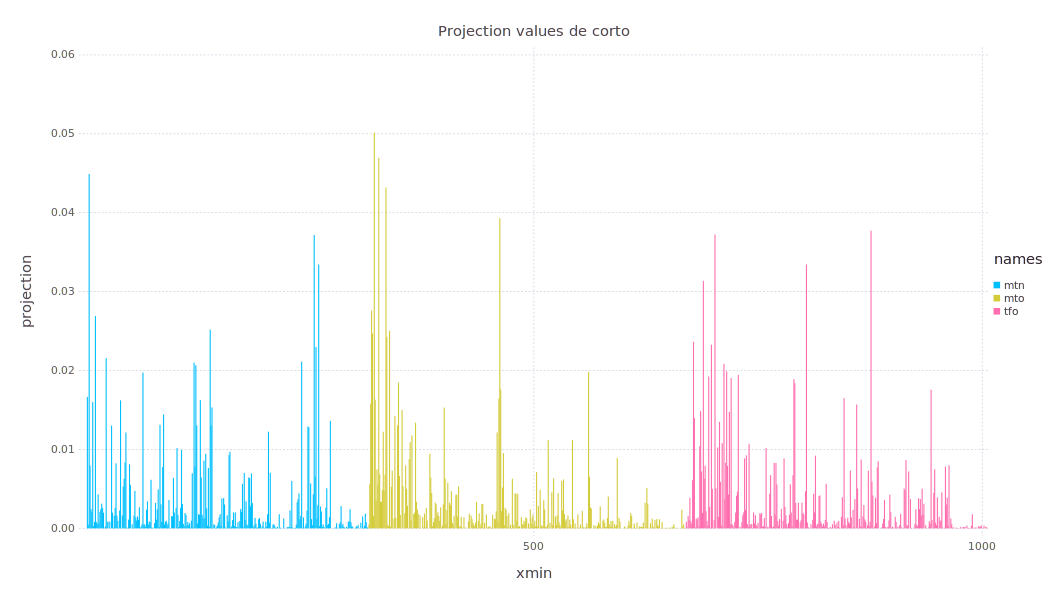

In [28]:
# Junto en un df
names = [repeat(["mtn"], inner=[length(pjtion_corto_mtn)]); 
    repeat(["mto"], inner=[length(pjtion_corto_mto)]); repeat(["tfo"], inner=[length(pjtion_corto_tfo)])]
pjtion_corto = [pjtion_corto_mtn; pjtion_corto_mto; pjtion_corto_tfo ]
df_pjtion_corto = DataFrame(projection=pjtion_corto, names=names);

# Hago el histograma
plot(df_pjtion_corto, xmin=collect(1:length(pjtion_corto_mto)), xmax=collect(1:length(pjtion_corto_mto)),
y="projection", 
color="names", 
Geom.bar(position=:dodge), 
#Theme(bar_spacing=1pt),
#Scale.x_continuous,
Guide.Title("Projection values de corto"),
Coord.Cartesian(xmin=1, xmax=1000))
#Guide.xticks(ticks = collect(1:1:11), orientation=:horizontal),
#Guide.yticks(ticks = collect(0.0:0.1:0.3), orientation=:horizontal), 
#Guide.xlabel("SSE participation number"), Guide.ylabel("relative probability"))

984-element Array{ASCIIString,1}:
 "mtn"
 "mtn"
 "mtn"
 "mtn"
 "mtn"
 "mtn"
 "mtn"
 "mtn"
 "mtn"
 "mtn"
 "mtn"
 "mtn"
 "mtn"
 ⋮    
 "tfo"
 "tfo"
 "tfo"
 "tfo"
 "tfo"
 "tfo"
 "tfo"
 "tfo"
 "tfo"
 "tfo"
 "tfo"
 "tfo"